In [1]:
# データのダウンロード
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
! unzip /content/NewsAggregatorDataset.zip

# pandasのインストールとインポート
! pip install pandas
import pandas as pd

--2022-04-13 05:15:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  23.9MB/s    in 1.2s    

2022-04-13 05:15:33 (23.9 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


### データ構成
ID　TITLE　URL　PUBLISHER　CATEGORY　STORY　HOSTNAME　TIMESTAMP

In [29]:
# data読み込み
df = pd.read_csv('/content/newsCorpora.csv', sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
# 記事の中身を確認
df.head(4)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793


In [30]:
# ============
# 50. データの入手・整形
# ============
from sklearn.model_selection import train_test_split

# df.locは単独および複数の要素の値を選択、取得、変更が可能
# isinはbool型を返す
df1 = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割 stratifyを設定することで訓練データとテストデータの指定した中身の割合を同じにすることができる
train, test = train_test_split(df1, test_size=0.2, shuffle=True, random_state=0, stratify=df1['CATEGORY'])

# データの保存
train.to_csv('train.txt', sep="\t", index=False)
test.to_csv('test.txt', sep="\t", index=False)

print(train['CATEGORY'].value_counts())
print(test['CATEGORY'].value_counts())

b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
b    1125
e    1056
t     305
m     182
Name: CATEGORY, dtype: int64


In [31]:
# ============
# 51. 特徴量抽出
# ============

from pandas.core.internals.managers import T
import string
import re

def preprocessing(text):
    # str.maketrans()は変換のためのテーブルを作成
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(table)              # 記号をスペースに置換
    text = text.lower()                       # 文字種の統一
    text = re.sub('[0-9]+', '0', text)        # 数字の置き換え

    return text

# データの再結合
df = pd.concat([train, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 目的変数の格納
t_data = df["CATEGORY"]

# TITLEの格納
x_data = df["TITLE"]

# TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000) 

# 特徴量抽出
x_data = vectorizer.fit_transform(x_data)
x_data = pd.DataFrame(x_data.toarray(), columns=vectorizer.get_feature_names())

# データ分割
x_train, x_test, t_train, t_test = train_test_split(x_data, t_data, test_size=0.2, shuffle=False, stratify=None)

print("訓練用：{} {}".format(x_train.shape, t_train.shape))
print("評価用：{} {}".format(x_test.shape, t_test.shape))

# データの保存
# x_train.to_csv('train.feature.txt', sep='\t', index=False)
# x_test.to_csv('test.feature.txt', sep='\t', index=False)

訓練用：(10672, 3000) (10672,)
評価用：(2668, 3000) (2668,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
# ============
# 52. 学習
# ============
from sklearn.linear_model import LogisticRegression

# モデルの学習
def train(x, y):
    classifier = LogisticRegression(random_state=123, max_iter=10000)
    classifier = classifier.fit(x, y)

    return classifier

model = train(x_train, t_train)

In [23]:
# ============
# 53. 予測
# ============
# 学習データの予測
train_pred = model.predict(x_train)

# 評価データの予測
test_pred = model.predict(x_test)

In [25]:
# ============
# 54. 正解率の計測
# ============
from sklearn.metrics import accuracy_score

# 学習データの正解率の計測
train_acc = accuracy_score(t_train, train_pred)
print("Train accuracy = %1.3f" % train_acc)

# 評価データの正解率の計測
test_acc = accuracy_score(t_test, test_pred)
print("Test accuracy = %1.3f" % test_acc)


Train accuracy = 0.934
Test accuracy = 0.875


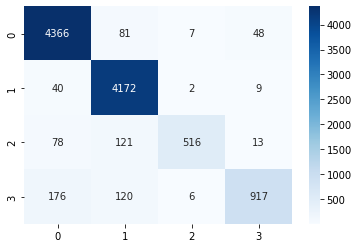

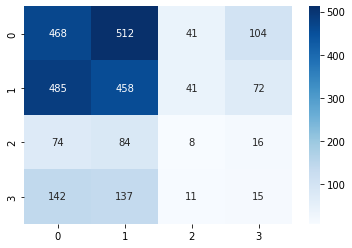

In [33]:
# ============
# 55. 混同行列の作成
# ============
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(t_train, train_pred)
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt="d")
plt.show()

# 評価データ
test_cm = confusion_matrix(t_test, test_pred)
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt="d")
plt.show()

In [34]:
# ============
# 56. 適合率、再現率、F1スコアの計測
# ============
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def calculate_scores(y_true, y_pred):
  # 適合率：予測で正例だった予測全体のうち、正解だった割合
  precision = precision_score(t_test, test_pred, average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率：
  recall = recall_score(t_test, test_pred, average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(t_test, test_pred, average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores

calculate_scores(t_test, test_pred)

,適合率,再現率,F1スコア
b,0.400342,0.416000,0.408021
e,0.384551,0.433712,0.407655
t,0.072464,0.049180,0.058594
m,0.079208,0.043956,0.056537
マイクロ平均,0.355697,0.355697,0.355697
マクロ平均,0.234141,0.235712,0.232702


In [35]:
# ============
# 57. 特徴量の重みの確認
# ============
features = x_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(model.classes_, model.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,fed,bank,stocks,ecb,china,euro,ukraine,yellen,oil,obamacare
重要度下位,and,ebola,the,video,she,her,microsoft,apple,facebook,star




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,she,her,kim,miley,cyrus,movie,thrones,paul
重要度下位,update,us,google,china,gm,study,ceo,facebook,apple,says




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,fda,cancer,mers,drug,cases,cdc,could,health
重要度下位,gm,facebook,apple,climate,ceo,bank,google,deal,sales,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,nasa,gm,tesla,fcc,heartbleed
重要度下位,stocks,fed,shares,cancer,her,percent,ukraine,thrones,american,ecb


In [39]:
# ============
# 58. 正則化パラメータの変更
# ============
result = []

# 10^-5 から 10^4
for C in np.logspace(-5, 4, 10, base=10): 
  # モデルの学習
  classifier = LogisticRegression(random_state=123, max_iter=10000, C=C)
  classifier.fit(x_train, t_train)

  # 予測値の取得
  train_pred = classifier.predict(x_train)
  test_pred = classifier.predict(x_test)

  # 正解率の算出
  train_accuracy = accuracy_score(t_train, train_pred)
  test_accuracy = accuracy_score(t_test, test_pred)

  # 結果の格納
  result.append([C, train_accuracy, test_accuracy])

In [46]:
print(result)

[[1.00000000e-05 4.21851574e-01 4.21664168e-01]
 [1.00000000e-04 4.21851574e-01 4.21664168e-01]
 [1.00000000e-03 4.65985757e-01 4.64767616e-01]
 [1.00000000e-02 7.64430285e-01 7.53373313e-01]
 [1.00000000e-01 8.05191154e-01 7.81859070e-01]
 [1.00000000e+00 9.34314093e-01 8.75187406e-01]
 [1.00000000e+01 9.87350075e-01 8.91679160e-01]
 [1.00000000e+02 9.98032234e-01 8.83808096e-01]
 [1.00000000e+03 9.98875562e-01 8.71064468e-01]
 [1.00000000e+04 9.99062969e-01 8.61694153e-01]]


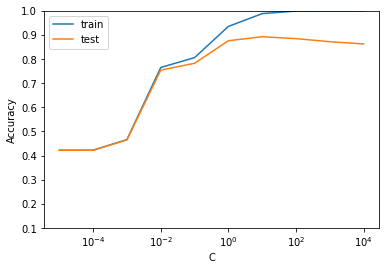

In [49]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='test')
plt.ylim(0.1, 1.0)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

In [50]:
# K分割交差検証の実施
from sklearn.model_selection import cross_val_score

# 5分割交差検証による汎化性能の評価
scores = cross_val_score(model, x_data, t_data, cv=5)

# 評価結果の出力
print("5分割交差検証による汎化性能の評価: {}".format(100 * scores.mean()))

5分割交差検証による汎化性能の評価: 88.61319340329835


In [18]:
# Optunaのインストール
! pip install --quiet optuna

In [57]:
# ============
# 59. ハイパーパラメータの探索（修正）
# ============
import optuna
from sklearn.model_selection import cross_validate

class Objective:
    def __init__(self, X, y):
        # 変数X, yの初期化
        self.x = X
        self.y = y

    def __call__(self, trial):
        params = {
            'C':trial.suggest_loguniform('C', 0.0001, 10)
        }

        model = LogisticRegression(**params)

        scores = cross_validate(model,
                                X=self.x,
                                y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        return scores['test_score'].mean()

# ハイパラ探索
objective = Objective(x_train, t_train)
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=1200)

# ベストパラメータを出力
print('params:', study.best_params)

[I 2022-04-13 06:19:39,923] A new study created in memory with name: no-name-94adefa5-dd07-465c-8f63-ca9172b0a622
[I 2022-04-13 06:19:48,724] Trial 0 finished with value: 0.6251875182448108 and parameters: {'C': 0.0027912471824399487}. Best is trial 0 with value: 0.6251875182448108.
[I 2022-04-13 06:20:38,111] Trial 1 finished with value: 0.8943027903311831 and parameters: {'C': 2.357573287826885}. Best is trial 1 with value: 0.8943027903311831.
[I 2022-04-13 06:20:45,675] Trial 2 finished with value: 0.711956260741118 and parameters: {'C': 0.004965282047240148}. Best is trial 1 with value: 0.8943027903311831.
[I 2022-04-13 06:21:36,009] Trial 3 finished with value: 0.8928971552361784 and parameters: {'C': 2.218516608924021}. Best is trial 1 with value: 0.8943027903311831.
[I 2022-04-13 06:22:24,297] Trial 4 finished with value: 0.8866193600214218 and parameters: {'C': 1.4064842406366442}. Best is trial 1 with value: 0.8943027903311831.
[I 2022-04-13 06:22:33,395] Trial 5 finished with

params: {'C': 9.148301437215446}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 89.16792


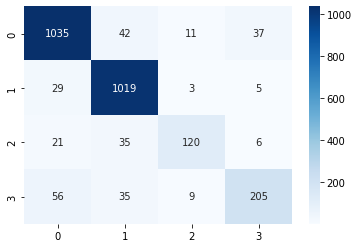

In [58]:
# ハイパーパラメータ探索で特定した値を設定
model = LogisticRegression(
    C = study.best_params['C'],
)

model.fit(x_train, t_train)
pred = model.predict(x_test)
# 正解率の出力
print("Accuracy: {:.5f}".format(100 * accuracy_score(t_test, pred)))

# 混同行列の出力
cm = confusion_matrix(t_test, pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.show()